In [1]:
# Add this at the beginning of the notebook, before any other imports
import sys
import os

sys.path.append(os.path.dirname(os.path.abspath('.')))

In [2]:
from langchain_core.messages import HumanMessage, BaseMessage

from typing import Annotated, Any, Dict, Sequence, TypedDict

import json
import pandas as pd
import numpy as np

import yfinance as yf
import pandas as pd
import numpy as np
from typing import Dict, List, Tuple, Optional


from langgraph.graph import StateGraph, END

from typing import (
    Annotated,
    Sequence,
    TypedDict,
)
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

import json
from langchain_core.messages import ToolMessage, SystemMessage
from langchain_core.runnables import RunnableConfig

from agents.utils import NewsAnalystState
from tools.yfinance_news import yf_tool
from tools.ddg_search import ddg_search
from agents.news_analyst_prompts import NEWS_ANALYST_AGENT_SYSTEM_PROMPT

from langchain_openai import ChatOpenAI
from langchain_ollama import ChatOllama
from langchain_core.tools import tool

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [3]:
arg_query_prompt = """\
This query will be used in a search engine to find the most relevant news for user, \
so please generate a good search query based on user query.
"""

arg_entities_prompt = """\
all entities that mentioned in user query. If no specific entities mentioned, return empty list.
Example: "will deepseek affect nvdia stock price?" -> ["deepseek", "nvdia"]; "competition between AMD and Nvidia" -> ["AMD", "Nvidia"]\
"""

In [4]:
arg_entities_prompt

'all entities that mentioned in user query. If no specific entities mentioned, return empty list.\nExample: "will deepseek affect nvdia stock price?" -> ["deepseek", "nvdia"]; "competition between AMD and Nvidia" -> ["AMD", "Nvidia"]'

In [5]:
@tool
def news_retriever(
    query: Annotated[str, arg_query_prompt],
    entities: Annotated[list[str], arg_entities_prompt],
) -> Tuple[str, list[str]]:
    """Tool that retrieves news, articles, and research reports"""
    return query, entities


tools = [news_retriever]
tools_by_name = {tool.name: tool for tool in tools}

# model = ChatOpenAI(model="gpt-4o-mini")

model = ChatOllama(
    model="llama3.2:latest",
    temperature=0,
)


model = model.bind_tools(tools)

In [6]:
query = "will deepseek affect nvdia stock price?"

In [7]:
res = model.invoke(
    [HumanMessage(content=query)],
)
res

AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2:latest', 'created_at': '2025-01-27T01:46:12.217166Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1350012541, 'load_duration': 30220166, 'prompt_eval_count': 279, 'prompt_eval_duration': 547000000, 'eval_count': 41, 'eval_duration': 772000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-3f52061a-ea53-4a81-94d1-70ab09c59f7b-0', tool_calls=[{'name': 'news_retriever', 'args': {'entities': ['deepseek', 'nvdia'], 'query': 'will deepseek affect nvdia stock price'}, 'id': '80b4dc83-d9a0-49d6-8962-05ec91020b71', 'type': 'tool_call'}], usage_metadata={'input_tokens': 279, 'output_tokens': 41, 'total_tokens': 320})

In [8]:
res.tool_calls[0]

{'name': 'news_retriever',
 'args': {'entities': ['deepseek', 'nvdia'],
  'query': 'will deepseek affect nvdia stock price'},
 'id': '80b4dc83-d9a0-49d6-8962-05ec91020b71',
 'type': 'tool_call'}

In [9]:
res.tool_calls[0]["args"]

{'entities': ['deepseek', 'nvdia'],
 'query': 'will deepseek affect nvdia stock price'}

In [10]:
from itertools import chain
from concurrent.futures import ThreadPoolExecutor
import time
from functools import partial

def retry_with_backoff(func, *args, max_retries=3, initial_delay=1):
    """Retry a function with exponential backoff"""
    for attempt in range(max_retries):
        try:
            return func(*args)
        except Exception as e:
            if attempt == max_retries - 1:  # Last attempt
                print(f"Failed after {max_retries} attempts: {str(e)}")
                return []  # Return empty list on complete failure
            
            delay = initial_delay * (2 ** attempt)  # Exponential backoff
            print(f"error: {e}")
            print(f"Attempt {attempt + 1} failed, retrying in {delay} seconds...")
            time.sleep(delay)
    
    return []  # Fallback return if somehow we get here


def invoke_tools(query: str, entities: list[str]):
    print(f"alex-debug query: {query}, entities: {entities}")
    # Define all your functions and their arguments in a list of tuples
    tasks = [
        
        (partial(retry_with_backoff, ddg_search.invoke), query),
        # (yet_another_function, query, additional_arg),
        # Add more functions as needed
    ]
    if entities:
        for entity in entities:
            tasks.append(
                (partial(retry_with_backoff, yf_tool.invoke), entity)
            )

    remove_duplicates = set()
    filtered_res_lst = []
    with ThreadPoolExecutor() as executor:
        # Submit all tasks
        futures = [executor.submit(func, *args) for func, *args in tasks]
        # Get all results
        res_lst = [future.result() for future in futures]
        res_lst = list(chain.from_iterable(res_lst))
    
    print(f"alex-debug res_lst: {res_lst}")

    for r in res_lst:
        if r["link"] not in remove_duplicates:
            remove_duplicates.add(r["link"])
            filtered_res_lst.append(r)
    return filtered_res_lst

In [11]:
# res = invoke_tools("trump meme coin")
# res


In [12]:
def node_call_tools(state: NewsAnalystState):
    tool_call = state["messages"][-1].tool_calls[0]
    query = tool_call["args"]["query"]
    entities = tool_call["args"]["entities"]

    response = invoke_tools(query, entities)
    
    print(f"alex-debug news retriever response: {response}")
    content = json.dumps([
        {
            "title": item["title"],
            "description": item["description"]
        } for item in response
    ])
    message = ToolMessage(
        content=content,
        name="news_retriever",
        tool_call_id=tool_call["id"],
    )
    print(f"alex-debug fyinance news message: {message}")
    return {
        "messages": [message],
        "metadata": {
            "news": response
        }
    }


In [13]:
# Define the node that calls the model
def call_model(
    state: NewsAnalystState,
    config: RunnableConfig,
):
    system_prompt = SystemMessage(NEWS_ANALYST_AGENT_SYSTEM_PROMPT)
    response = model.invoke([system_prompt] + state["messages"], config)
    return {"messages": [response]}


def should_continue(state: NewsAnalystState):
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return [END]
    else:
        return ["news_retriever"]


def news_analyst_agent():
    workflow = StateGraph(NewsAnalystState)

    workflow.add_node("agent", call_model)
    workflow.add_node("news_retriever", node_call_tools)

    workflow.set_entry_point("agent")
    workflow.add_conditional_edges(
        "agent",
        should_continue,
        ["news_retriever", END]
    )
    workflow.add_edge("news_retriever", "agent")

    graph = workflow.compile()

    return graph


In [14]:
news_graph = news_analyst_agent()

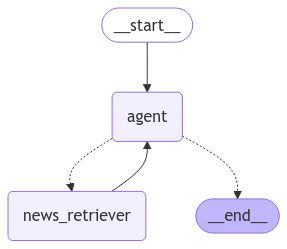

In [15]:
from IPython.display import Image, display

display(Image(news_graph.get_graph().draw_mermaid_png()))

In [16]:
from uuid import uuid4

thread_id = str(uuid4())
thread_id

'27f5d727-8d5b-4baa-8322-d4e00766c176'

In [17]:
res = news_graph.invoke(
    input={
        "messages": [HumanMessage(content="will deepseek affect nvdia stock price?")],
        "metadata": {}
    },
    # config={
    #     "configurable": {
    #         "thread_id": thread_id
    #     }
    # }
)

2025-01-26 20:46:28.060 | DEBUG    | tools.ddg_search:_run:49 - Use ddg_search tool with query: Will DeepSeek affect NVIDIA stock price
2025-01-26 20:46:28.061 | DEBUG    | tools.yfinance_news:_run:42 - Use yfinance_news tool with query: deepseek
2025-01-26 20:46:28.061 | DEBUG    | tools.yfinance_news:_run:42 - Use yfinance_news tool with query: nvidia


alex-debug query: Will DeepSeek affect NVIDIA stock price, entities: ['DeepSeek', 'NVIDIA']
alex-debug ddg: [{'title': "Nvidia Stock May Fall As DeepSeek's 'Amazing' AI Model Disrupts OpenAI", 'description': 'Barrett Woodside, co-founder of the San Francisco AI hardware company Positron, said he and his colleagues have been abuzz about DeepSeek.', 'content': None, 'link': 'https://www.forbes.com/sites/petercohan/2025/01/26/nvidia-stock-may-fall-as-deepseeks-amazing-ai-model-disrupts-openai/', 'source': 'ddg'}, {'title': 'Chinese AI lab DeepSeek rattles Silicon Valley', 'description': 'Chinese AI lab DeepSeek shakes up Silicon Valley with top-performing language model, challenging American tech dominance.', 'content': None, 'link': 'https://www.msn.com/en-us/money/other/chinese-ai-lab-deepseek-rattles-silicon-valley/ar-AA1xTotb', 'source': 'ddg'}, {'title': 'How small Chinese AI start-up DeepSeek shocked Silicon Valley', 'description': "Hedge fund billionaire Liang Wenfeng builds model 

In [18]:
res["messages"][-1]

AIMessage(content='Based on the news retrieved, it appears that DeepSeek\'s recent breakthroughs in AI research may have an impact on NVIDIA\'s stock price. The Chinese AI lab DeepSeek has released an open version of its reasoning model R1, which seems to match or beat OpenAI\'s o1 model on certain AI benchmarks. This development has been described as "one of the most amazing and impressive breakthroughs I\'ve ever seen" by venture capitalist Marc Andreessen.\n\nThe potential impact on NVIDIA\'s stock price is uncertain, but it\'s possible that investors may reassess the company\'s position in the AI chip market given DeepSeek\'s advancements. Some analysts have already expressed concerns about NVIDIA\'s dominance in the AI chip market, and this news may further erode investor confidence.\n\nHowever, it\'s essential to note that NVIDIA has a strong track record of innovation and has been investing heavily in AI research. The company\'s revenue and profits have soared in recent years, a

In [19]:
res["messages"][-1].content

'Based on the news retrieved, it appears that DeepSeek\'s recent breakthroughs in AI research may have an impact on NVIDIA\'s stock price. The Chinese AI lab DeepSeek has released an open version of its reasoning model R1, which seems to match or beat OpenAI\'s o1 model on certain AI benchmarks. This development has been described as "one of the most amazing and impressive breakthroughs I\'ve ever seen" by venture capitalist Marc Andreessen.\n\nThe potential impact on NVIDIA\'s stock price is uncertain, but it\'s possible that investors may reassess the company\'s position in the AI chip market given DeepSeek\'s advancements. Some analysts have already expressed concerns about NVIDIA\'s dominance in the AI chip market, and this news may further erode investor confidence.\n\nHowever, it\'s essential to note that NVIDIA has a strong track record of innovation and has been investing heavily in AI research. The company\'s revenue and profits have soared in recent years, and investors remai

In [20]:
from IPython.display import display, Markdown

# ... existing code ...

# Instead of just printing the content directly
display(Markdown(res["messages"][-1].content))

Based on the news retrieved, it appears that DeepSeek, a Chinese AI lab, has developed a top-performing language model that is challenging American tech dominance. This development may affect NVIDIA's stock price as it competes with other AI companies.

Summary of key points:

* DeepSeek has developed a powerful language model that is shaking up Silicon Valley.
* The company's success challenges American tech dominance in the AI sector.
* NVIDIA, a leading GPU manufacturer, may be affected by this development as it competes with other AI companies.

Analysis of potential market impacts:

* The emergence of DeepSeek as a major player in the AI sector could lead to increased competition for NVIDIA and other American tech companies.
* This competition may put pressure on NVIDIA's stock price, potentially leading to a correction or decline.
* However, NVIDIA's dominant position in the GPU market and its efforts to expand into AI-related fields may help it maintain its market share and continue to perform well.

Risks and opportunities:

* Risks: Increased competition from DeepSeek and other Chinese AI companies could lead to a decline in NVIDIA's stock price.
* Opportunities: NVIDIA's strong position in the GPU market and its expansion into AI-related fields provide opportunities for growth and increased profitability.

Context and broader market perspective:

* The emergence of DeepSeek as a major player in the AI sector is part of a larger trend of increasing competition from Chinese tech companies in various industries.
* This trend has significant implications for American tech companies, including NVIDIA, and may lead to changes in the global technology landscape.
* The impact of DeepSeek on NVIDIA's stock price will depend on various factors, including the company's ability to adapt to changing market conditions and its continued innovation in AI-related fields.

In [20]:
from IPython.display import display, Markdown

# ... existing code ...

# Instead of just printing the content directly
display(Markdown(res["messages"][-1].content))

Based on the news retrieved, it appears that DeepSeek's recent breakthroughs in AI research may have an impact on NVIDIA's stock price. The Chinese AI lab DeepSeek has released an open version of its reasoning model R1, which seems to match or beat OpenAI's o1 model on certain AI benchmarks. This development has been described as "one of the most amazing and impressive breakthroughs I've ever seen" by venture capitalist Marc Andreessen.

The potential impact on NVIDIA's stock price is uncertain, but it's possible that investors may reassess the company's position in the AI chip market given DeepSeek's advancements. Some analysts have already expressed concerns about NVIDIA's dominance in the AI chip market, and this news may further erode investor confidence.

However, it's essential to note that NVIDIA has a strong track record of innovation and has been investing heavily in AI research. The company's revenue and profits have soared in recent years, and investors remain bullish on the stock.

In conclusion, while DeepSeek's breakthroughs may have an impact on NVIDIA's stock price, the potential effects are uncertain and will depend on various factors, including how NVIDIA responds to the competition and the overall market sentiment.